In this notebook, I'll implement a content-based filtering recommendation system that focuses on the metadata of the videos and gives the recommendations based on the similarity between them. The general idea behind this type of recommender system is that if a person liked a particular video, he or she will also like a video that is similar to it.

## Data Preparation
Let's load the data and take a peak at the content

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading the data file
# Only use the columns I need
data = pd.read_csv('csv-data/sample_data_ML_format.csv', encoding='latin-1', usecols=['video_id', 'feature_names', 'title', 'description', 'duration'])

In [2]:
# Check the file info
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 5 columns):
video_id         389 non-null object
feature_names    389 non-null object
title            373 non-null object
description      387 non-null object
duration         389 non-null float64
dtypes: float64(1), object(4)
memory usage: 15.3+ KB
None


## Data Analysis
### Video Titles
Are there certain words that feature more often in **Video Titles**? I'll attempt to figure this out using a word-cloud visualization.

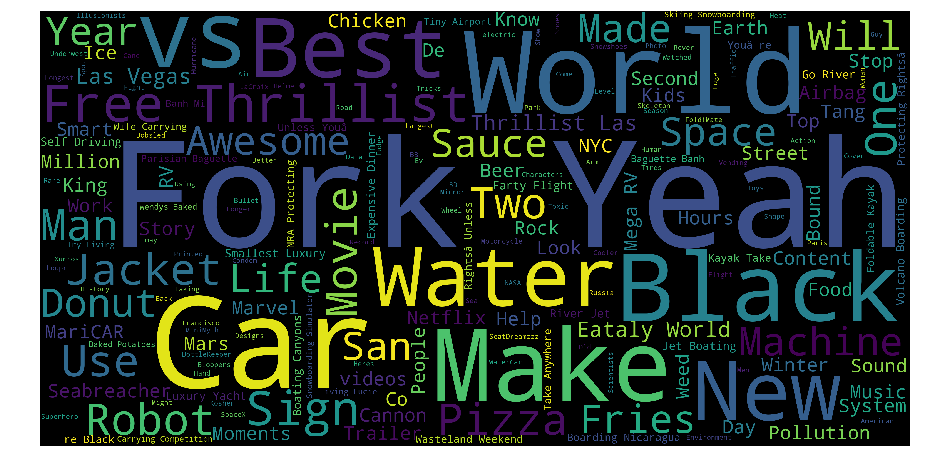

In [3]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the video titles
data['title'] = data['title'].fillna("").astype('str')
title_corpus = ' '.join(data['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

### Feature Names 
This metadata variable will surely be important while building the recommendation engines since it partially describes the content of the video. A basic assumption is that videos with similar features should have similar contents. I'll attempt to see exactly which phrases are the most popular.

In [4]:
# Make a census of the feature keywords
feature_labels = set()
for s in data['feature_names'].str.split(',').values:
    feature_labels = feature_labels.union(set(s))

# Function that counts the number of times each of the feature keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split(','):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of feature keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(data, 'feature_names', feature_labels)
keyword_occurences[:10]

[[' Car', 389],
 [' Person', 383],
 [' People', 382],
 [' Automobile', 381],
 [' Human', 366],
 [' Word', 332],
 [' Vehicle', 296],
 [' Poster', 287],
 [' Logo', 257],
 [' Trademark', 257]]

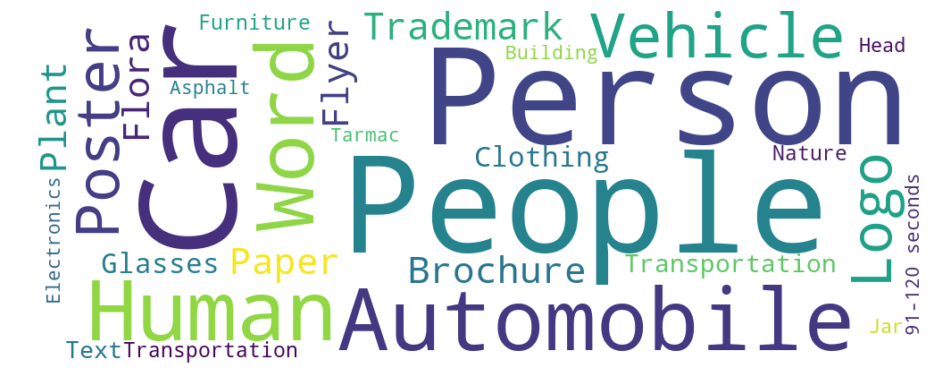

In [5]:
# Define the dictionary used to produce the feature wordcloud
features = dict()
trunc_occurences = keyword_occurences[0:29]
for s in trunc_occurences:
    features[s[0]] = s[1]

# Create the wordcloud
feature_wordcloud = WordCloud(width=1000,height=400, background_color='white')
feature_wordcloud.generate_from_frequencies(features)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(feature_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Video Description
This metadata variable will also be important while building the recommendation engines since it also partially describes the content of the video. A basic assumption is that videos with similar description should have similar contents. I'll attempt to see words thate feature more often in the video descriptions.

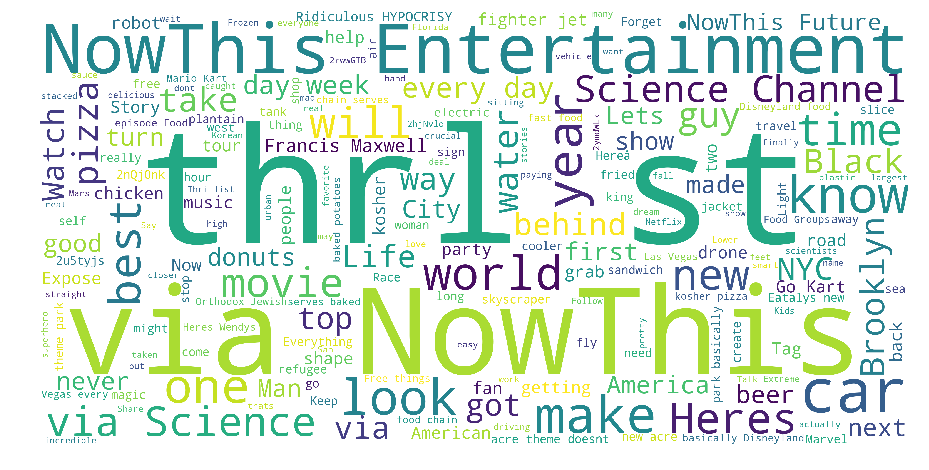

In [6]:
%matplotlib inline

# Create a wordcloud of the video descriptions
data['description'] = data['description'].fillna("").astype('str')
description_corpus = ' '.join(data['description'])
description_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(description_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()

## Content-Based Recommender
### Description-Based Recommender
In this section, I will try to build a system that recommends videos that are similar to a particular video. More specifically, I will compute pairwise similarity scores for all videos based on their descriptions and recommend videos based on that similarity score. Again, the video description is available as the `description` feature in our dataset. Let's inspect the descriptions of a few videos:

In [7]:
# Print description of the first 10 videos
print(data['description'].head(10))

0                      Turn your car into a snow tank.
1    How many space questions can you get right? (v...
2    This smart helmet will make you feel like Iron...
3    There could be plastic in your drinking water....
4    This is the latest internet trend we dont unde...
5    Heres the film we think will win Best Picture ...
6    These visual tricksters create mind-blowing op...
7              This RV is basically a yacht on wheels.
8    Extremely high levels of E. coli were found in...
9    Mercedes-Benz might hire Linkin Park to make s...
Name: description, dtype: object


In its current form, it is not possible to compute the similarity between any two descriptions. To do this, I need to compute the word vectors of each description.

I will compute **Term Frequency-Inverse Document Frequency (TF-IDF)** vectors for each description. This will give me a matrix where each column represents a word in the description vocabulary (all the words that appear in at least one description) and each column represents a video, as before.

In its essence, the TF-IDF score is the frequency of a word occurring in a description, down-weighted by the number of descriptions in which it occurs. This is done to reduce the importance of words that occur frequently in descriptions and therefore, their significance in computing the final similarity score.

Fortunately, *scikit-learn* gives me a built-in *TfIdfVectorizer* class that produces the TF-IDF matrix in a couple of lines.

In [13]:
# Import TfidfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a' 
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

# Replace NaN with an empty string
data['description'] = data['description'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tf.fit_transform(data['description'])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

(389, 3172)

I can see that 3,172 different words were used to describe the 389 videos in the dataset.

With this matrix in hand, I can now compute a similarity score. There are several candidates for this; such as the *euclidean*, the *Pearson* and the *cosine* similarity scores. Again, there is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

I will be using the **cosine** similarity to calculate a numeric quantity that denotes the similarity between two videos. I use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate.

Since I have used the TF-IDF vectorizer, calculating the dot product will directly give me the cosine similarity score. Therefore, I will use sklearn's *linear_kernel()* instead of *cosine_similarities()* since it is faster.

In [14]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Show a sample of the matrix's scores
cosine_sim[:5, :5]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

I now have a pairwise cosine similarity matrix for all the videos in the dataset. The next step is to write a function that takes in a video title as an input and outputs a list of the 30 most similar videos. Firstly, for this, I need a reverse mapping of video titles and DataFrame indices. In other words, I need a mechanism to identify the index of a video in my `data` DataFrame, given its title.

In [15]:
# Construct a reverse map of indices and video titles
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

I are now in a good position to define the recommendation function. These are the following steps to follow:

* Get the index of the video given its title.
* Get the list of cosine similarity scores for that particular video with all videos. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 30 elements of this list. Ignore the first element as it refers to self (the video most similar to a particular video is that video itself).
* Return the titles corresponding to the indices of the top elements.

In [16]:
# Function that takes in video title as input and outputs most similar videos
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the video that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all videos with that video
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the videos based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 30 most similar videos
    sim_scores = sim_scores[1:31]
    
    # Get the video indices
    video_indices = [i[0] for i in sim_scores]
    
    # Access the title, feature_names, description, and duration metadata for these videos
    videos = data.iloc[video_indices][['title', 'feature_names', 'description', 'duration']]
    
    # Sort the videos based on descending duration
    videos = videos.sort_values('duration', ascending=False)
    
    # Return the top 30 most similar videos
    return videos

Let's look at the recommendations for a few videos and see how good the recommendations are.

In [17]:
get_recommendations('Smart Helmet')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Update
I tried to debug this problem but couldn't find a way. It seems like the problem lies in the dataset, where there's too much duplicate values. For example, here are the top duplicate *title* values:

In [18]:
df = data.groupby('title')['video_id'].nunique().sort_values(ascending=False).reset_index(name='count')
print(df.head(10))

                                  title  count
0                                           16
1                          Eataly World      4
2             Free Thrillist: Las Vegas      4
3                  Fork Yeah: 375 Fries      3
4                          Tiny Airport      3
5      The Worlds Most Expensive Dinner      3
6                       The Seabreacher      3
7                          Farty Flight      3
8  Foldable Kayak You Can Take Anywhere      3
9     Skiing and Snowboarding Simulator      3


As you can see, there are 16 null-values, as well as many values with 3 counts and up. Here are the top duplicate *description* values:

In [19]:
df = data.groupby('description')['video_id'].nunique().sort_values(ascending=False).reset_index(name='count')
print(df.head(10))

                                         description  count
0  Eatalys new 20-acre theme park is basically Di...      4
1                     When refugees make food magic.      3
2      Win the ultimate romantic dinner date for $2.      3
3  Hit the slopes without stepping outdoors. >> t...      3
4  Heres why Wendys is the only major fast-food c...      3
5                What is this, an airport for ants?!      3
6  Party like its the end of the world. >> thrl.s...      3
7  This floating spaceship is the worlds smallest...      3
8  These are the crispiest french fries in NYC: t...      3
9  Its officially cuffing season.  >> thrl.st/2x2...      3
